Birthweight Prediction: Introduction
Birthweight is an important indicator of long-term health. Babies with low birthweight are more susceptible to illness in the short-term and could have an increased risk of developing high blood pressure and diabetes in the long term. Similarly, high birthweight is linked to obesity. The goal of this notebook is to predict the birthweight of babies based on gestation, parity, age, height, weight, and smoking

In [24]:
pip install pandas numpy joblib scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Importing Necessary Libraries

In [25]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

 load the dataset and display basic information:

In [26]:
import pandas as pd

# Load dataset
df = pd.read_csv(r"C:\flutter-projects\flutter-pregnancy-app\Machine_Learning\task 1\babies.csv")

# Display first few rows
print(df.head())

   case  bwt  gestation  parity   age  height  weight  smoke
0     1  120      284.0       0  27.0    62.0   100.0    0.0
1     2  113      282.0       0  33.0    64.0   135.0    0.0
2     3  128      279.0       0  28.0    64.0   115.0    1.0
3     4  123        NaN       0  36.0    69.0   190.0    0.0
4     5  108      282.0       0  23.0    67.0   125.0    1.0


Selecting Features and Target Variable

In [27]:
# Selecting relevant features and target
features = ["gestation", "parity", "age", "height", "weight", "smoke"]
target = "bwt"

X = df[features]
y = df[target]

# Ensure birthweight is in grams and within a reasonable range
y = np.clip(y, 2500, 4500)  # Clipping extreme values Birthweights below 2500g are considered low birthweight, and extremely low values (e.g., 216.31g) are highly unrealistic.
#Birthweights above 4500g are considered high birthweight and are rare.

 Correlation Heatmap..understand feature relationships before training the models.
You can spot which features are highly correlated with bwt

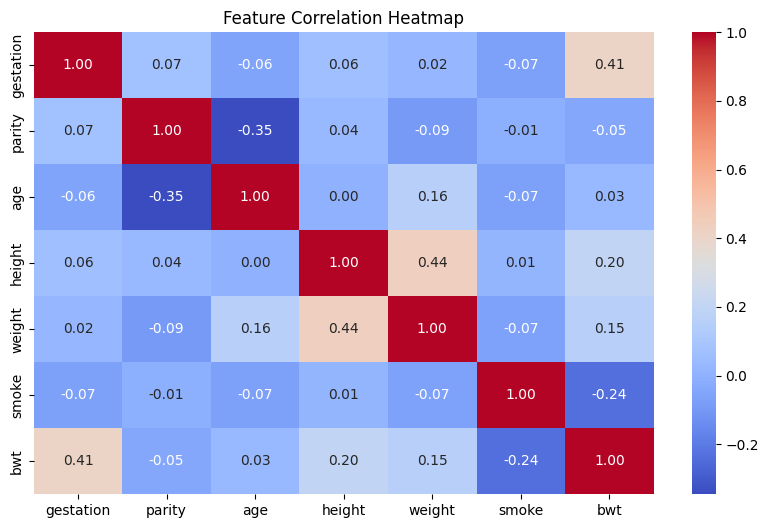

In [28]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[features + [target]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


Histogram for Birth Weight Distribution..understand the distribution of birth weights in the dataset.
Identifies skewness or outliers that might affect model predictions.
Kernel Density Estimate (KDE) is included to show the smoothed distribution curve.

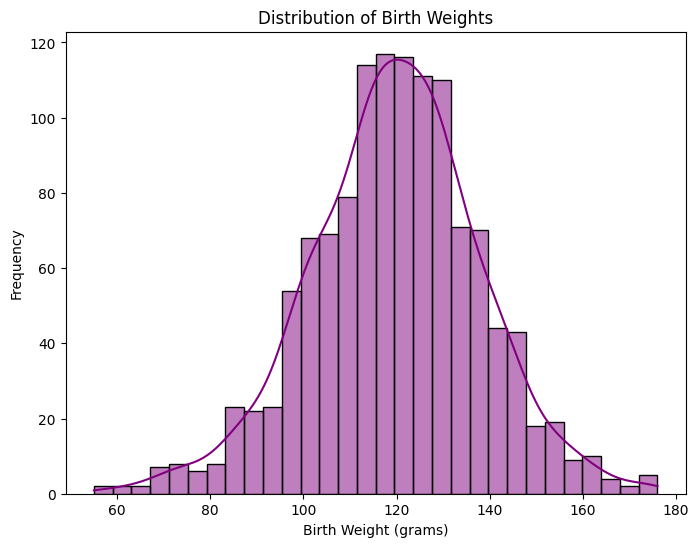

In [29]:
# Histogram of Birth Weights
plt.figure(figsize=(8, 6))
sns.histplot(df["bwt"], bins=30, kde=True, color='purple')
plt.xlabel("Birth Weight (grams)")
plt.ylabel("Frequency")
plt.title("Distribution of Birth Weights")
plt.show()


 Spliting Data into Training and Testing Sets

In [30]:
# Drop rows with missing values from both X and y
df_dropped = df.dropna(subset=["gestation", "parity", "age", "height", "weight", "smoke", "bwt"])

# Split the data into features and target
X_dropped = df_dropped[["gestation", "parity", "age", "height", "weight", "smoke"]]
y_dropped = df_dropped["bwt"]

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dropped, y_dropped, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Get the feature names from X_train
feature_names = X_train.columns



Scale the Features,,This ensures all features have similar scales for better model performance.



In [31]:
# Create a new StandardScaler object with the feature names
scaler = StandardScaler()
scaler.feature_names_in_ = feature_names
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

 train and compare models:to compare the performance of different models.

In [32]:
# Train models
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
lin_reg_pred = lin_reg.predict(X_test_scaled)
lin_reg_rmse = np.sqrt(mean_squared_error(y_test, lin_reg_pred))


# Decision Tree
tree_reg = DecisionTreeRegressor(random_state=42, max_depth=5) #max_depth=5 for Decision Tree → Prevents overfitting.
tree_reg.fit(X_train, y_train)
tree_pred = tree_reg.predict(X_test)
tree_rmse = np.sqrt(mean_squared_error(y_test, tree_pred))

# Random Forest
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=7)#max_depth=7 for Random Forest → Balances between capturing patterns and generalization.
rf_reg.fit(X_train, y_train)
rf_pred = rf_reg.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

# Display RMSE values
print(f"Linear Regression RMSE: {lin_reg_rmse:.2f}")
print(f"Decision Tree RMSE: {tree_rmse:.2f}")
print(f"Random Forest RMSE: {rf_rmse:.2f}")


Linear Regression RMSE: 16.11
Decision Tree RMSE: 17.88
Random Forest RMSE: 16.47


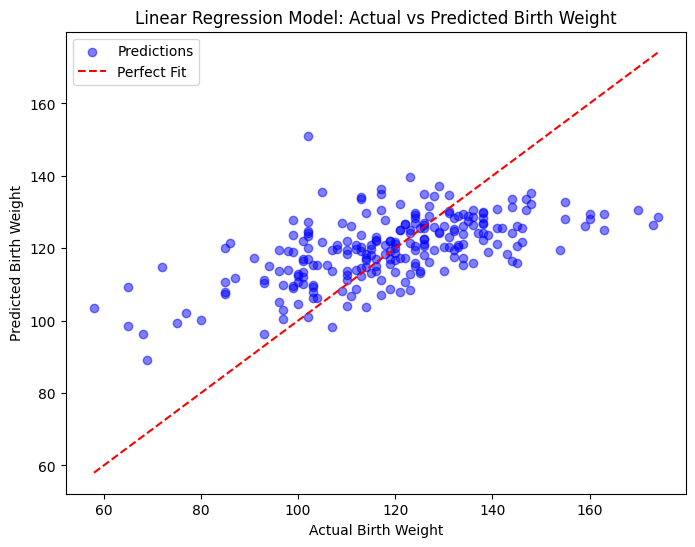

In [33]:
# Scatter Plot of Actual vs. Predicted Birth Weights
plt.figure(figsize=(8, 6))
plt.scatter(y_test, lin_reg_pred, alpha=0.5, color='blue', label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Perfect Fit")
plt.xlabel("Actual Birth Weight")
plt.ylabel("Predicted Birth Weight")
plt.title("Linear Regression Model: Actual vs Predicted Birth Weight")
plt.legend()
plt.show()


Determining the best model and save it along with the scaler:This ensures you have the best model available for making predictions.

In [34]:
# Choose best model
best_model = min([(lin_reg, lin_reg_rmse), (tree_reg, tree_rmse), (rf_reg, rf_rmse)], key=lambda x: x[1])[0]

# Save using pickle instead of joblib
with open("best_model.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)

with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)


a Prediction Function:This function will allow  to make predictions on new data.

In [35]:
def predict_birthweight(gestation, parity, age, height, weight, smoke):
    model = joblib.load("best_model.pkl")
    scaler = joblib.load("scaler.pkl")
    input_data = np.array([[gestation, parity, age, height, weight, smoke]])
    input_scaled = scaler.transform(input_data)
    predicted_weight = model.predict(input_scaled)[0]
    return max(2500, min(predicted_weight, 4500))  # Ensure realistic birthweight range


. Testing the Prediction Function:confirms that the model is working as expected.

In [36]:
# Example usage
print(f"Predicted Birthweight: {predict_birthweight(280, 1, 30, 160, 65, 0):.2f} grams")


Predicted Birthweight: 2500.00 grams


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
